# Data Mining Course Project
# Intrusion Detection System

## Name : Fraz Ahmad
## ID: SP17-BSE-003

In [2]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import operator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l1
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import normalize
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import TensorBoard
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import time

In [3]:
dataPath = ""
resultPath = 'results'
if not os.path.exists(resultPath):
    print('result path {} created.'.format(resultPath))
    os.mkdir(resultPath)

In [4]:
def loadData(fileName):
    dataFile = os.path.join(dataPath, fileName)
    df = pd.read_csv(dataFile)
    return df

In [5]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataPath = "/content/drive/My Drive/Colab Notebooks/data"

In [8]:
data = loadData('IDS-2017-binaryclass.csv')
data = data.astype('float64')
data = clean_dataset(data)

validation_data = data[0:1000]
validation_data.to_csv('validation_data_IDS.csv')

data = data[1000:]

x_data , y_data = data.drop('Label',axis = 1), data.Label
x_data = preprocessing.normalize(x_data.values)

In [9]:
data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1000,443.0,74336080.0,11.0,8.0,1055.0,31.0,1055.0,0.0,95.909091,318.094469,31.0,0.0,3.875000,10.960155,14.609326,0.255596,4129782.222,4.913845e+06,10000000.0,44.0,74300000.0,7433608.000,4.363197e+06,10100000.0,44.0,64300000.0,9181664.286,2.376891e+06,10100000.0,3791383.0,1.0,0.0,0.0,0.0,352.0,256.0,0.147977,0.107619,0.0,1055.0,107.050000,324.265725,105148.2605,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,112.684211,95.909091,3.875000,352.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1055.0,8.0,31.0,317.0,317.0,0.0,32.0,48628.42857,4711.347396,50530.0,37946.0,10000000.00,20246.94648,10000000.0,9976027.0,0.0
1001,443.0,115708519.0,24.0,19.0,2149.0,5569.0,1059.0,0.0,89.541667,254.624870,1418.0,0.0,293.105263,506.648343,66.702090,0.371623,2754964.738,4.428729e+06,10015471.0,7.0,115708519.0,5030805.174,4.992940e+06,10052004.0,49.0,111144935.0,6174718.611,4.995464e+06,10052147.0,48.0,0.0,0.0,0.0,0.0,776.0,616.0,0.207418,0.164206,0.0,1418.0,175.409091,391.258097,153082.8985,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,179.488372,89.541667,293.105263,776.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,2149.0,19.0,5569.0,29200.0,381.0,5.0,32.0,93565.72727,189559.186600,665108.0,36279.0,10010544.64,4919.82671,10015471.0,9996137.0,0.0
1002,443.0,116942443.0,13.0,13.0,588.0,4097.0,202.0,0.0,45.230769,67.763257,1430.0,0.0,315.153846,531.570918,40.062443,0.222332,4677697.720,1.610000e+07,58400000.0,1.0,117000000.0,9745203.583,2.270000e+07,58400000.0,92.0,117000000.0,9737989.417,2.270000e+07,58500000.0,1.0,0.0,0.0,0.0,0.0,272.0,272.0,0.111166,0.111166,0.0,1430.0,173.518518,389.810641,151952.3362,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,180.192308,45.230769,315.153846,272.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,588.0,13.0,4097.0,8192.0,351.0,6.0,20.0,145541.50000,73600.623530,197585.0,93498.0,58300000.00,172057.46460,58400000.0,58200000.0,0.0
1003,50372.0,215.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,9302.325581,215.000,0.000000e+00,215.0,215.0,215.0,215.000,0.000000e+00,215.0,215.0,0.0,0.000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,9302.325581,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,55.0,-1.0,0.0,20.0,0.00000,0.000000,0.0,0.0,0.00,0.00000,0.0,0.0,0.0
1004,53722.0,10890.0,1.0,2.0,0.0,12.0,0.0,0.0,0.000000,0.000000,6.0,6.0,6.000000,0.000000,1101.928375,275.482094,5445.000,6.447400e+03,10004.0,886.0,0.0,0.000,0.000000e+00,0.0,0.0,10004.0,10004.000,0.000000e+00,10004.0,10004.0,0.0,0.0,0.0,0.0,32.0,40.0,91.827365,183.654729,0.0,6.0,3.000000,3.464102,12.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.000000,0.000000,6.000000,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,12.0,235.0,0.0,

In [10]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2826876.0,2.826876e+06,2826876.0,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2826876.0,2826876.0,2826876.0,2826876.0,2826876.0,2826876.0,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06,2.826876e+06
mean,8.061642e+03,1.480118e+07,9.370409e+00,1.040590e+01,5.498556e+02,1.618326e+04,2.078039e+02,1.872888e+01,5.825496e+01,6.897668e+01,8.717405e+02,4.108860e+01,3.062590e+02,3.356670e+02,1.491562e+06,7.085144e+04,1.299726e+06,2.922281e+06,9.191991e+06,1.624999e+05,1.449817e+07,2.612779e+06,3.270387e+06,9.052294e+06,1.022820e+06,9.904341e+06,1.807540e+06,1.487625e+06,4.689619e+06,9.680954e+05,4.639538e-02,0.0,1.110767e-04,0.0,-2.603305e+04,-2.276440e+03,6.392737e+04,7.002241e+03,1.644865e+01,9.513637e+02,1.721130e+02,2.952698e+02,4.866262e+05,3.528559e-02,4.639538e-02,2.426707e-04,2.982780e-01,3.153145e-01,9.482906e-02,1.110767e-04,2.437320e-04,6.838492e-01,1.921696e+02,5.825496e+01,3.062590e+02,-2.603305e+04,0.0,0.0,0.0,0.0,0.0,0.0,9.370409e+00,5.498451e+02,1.040590e+01,1.618291e+04,6.992428e+03,1.988362e+03,5.424478e+00,-2.745474e+03,8.164183e+04,4.118132e+04,1.533534e+05,5.835905e+04,8.324742e+06,5.043017e+05,8.704811e+06,7.928369e+06,1.968070e-01
std,1.827448e+04,3.366841e+07,7.501853e+02,9.980701e+02,1.000028e+04,2.264635e+06,7.174767e+02,6.034887e+01,1.861650e+02,2.812961e+02,1.947154e+03,6.887448e+01,6.054828e+02,8.400406e+02,2.593947e+07,2.544114e+05,4.509727e+06,8.049443e+06,2.447054e+07,2.951308e+06,3.359058e+07,9.529846e+06,9.643555e+06,2.454024e+07,8.595296e+06,2.875047e+07,8.891074e+06,6.281838e+06,1.716944e+07,8.312555e+06,2.103399e-01,0.0,1.053871e-02,0.0,2.106725e+07,1.453202e+06,2.476501e+05,3.817052e+04,2.523561e+01,2.029018e+03,3.055940e+02,6.320356e+02,1.648144e+06,1.845008e-01,2.103399e-01,1.557600e-02,4.575023e-01,4.646411e-01,2.929787e-01,1.053871e-02,1.561002e-02,6.806016e-01,3.319673e+02,1.861650e+02,6.054828e+02,2.106725e+07,0.

In [29]:
def Model(inputDim):
    model = Sequential()
    model.add(Dense(1024, activation = 'relu' , input_shape = (inputDim,)))
    model.add(Dense(512, activation = 'relu', kernel_regularizer='l1'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(256, activation = 'relu', kernel_regularizer='l1'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1 , activation = 'sigmoid'))
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer= opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    
    return model

In [30]:
def TrainAndTest(x_data, y_data,optimizer='adam',epochs=50, batch_size = 256):
    
    #Creating data for analysis
    time_gen = int(time.time())
    #global model_name
    file_name="IDS_binaryclass"
    model_name = "{}_{}".format(file_name, time_gen)
    #$ tensorboard --logdir=logs/
    #tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))
    
    X_train , X_test , y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
    y_train = y_train.values.reshape(y_train.shape[0],1)
    y_test = y_test.values.reshape(y_test.shape[0],1)

    print("X train shape : ", X_train.shape , " y train shape : " , y_train.shape)
      
    model = Model(x_data.shape[1])
    
    history = model.fit(x=X_train,y= y_train, epochs=epochs, batch_size=batch_size,verbose=1)
    
    pred = model.evaluate(X_test, y_test, verbose = 1)
    
    print(model.metrics_names)
    val_acc, val_loss = pred[1]*100, pred[0]*100
    print('Test Data: accuracy: {:.2f}%: loss: {:.2f}'.format(val_acc, val_loss))

    model.save("results/models/{}acc{}.model".format(model_name,val_acc))

    resultFile = os.path.join(resultPath, file_name)
    with open('{}.result'.format(resultFile), 'a') as fout:
        fout.write('{} results...'.format(model_name))
        fout.write('\taccuracy: {:.2f} loss: {:.2f}'.format(val_acc, val_loss))

    return model ,history, val_acc, val_loss

In [31]:
x_data.shape

(2826876, 78)

In [32]:
model ,history , val_acc , val_loss = TrainAndTest(x_data, y_data, epochs = 30)

X train shape :  (2261500, 78)  y train shape :  (2261500, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1024)              80896     
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
__________________________________________________________

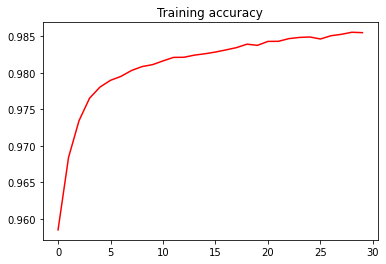

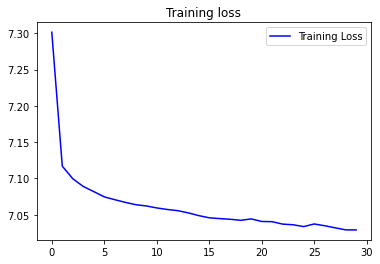

In [41]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.savefig('graph_training_acc_96%.png')

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.savefig('graph_training_loss_7.2260.png')
plt.legend()

plt.show()